##  CIFAR-10

In [5]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보는게 좋다. 
# 한꺼번에 정보가 나와서 직관적으로 이해하기 좋은듯
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


## Input Normalization

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_info.features["label"].num_classes

10

In [10]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

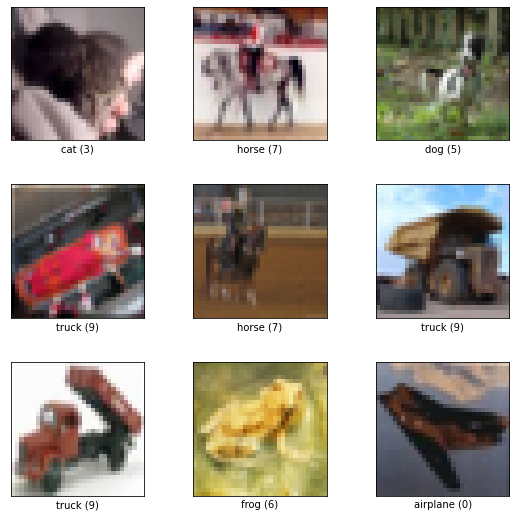

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

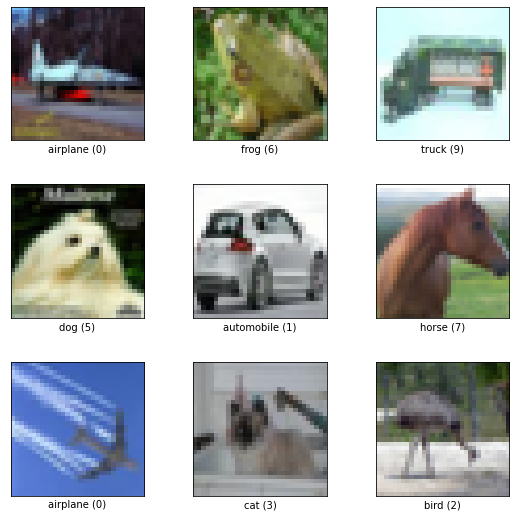

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

## ResNet 기본 블록 구성하기

In [174]:
def identity_block(input_tensor, num_cnn, is_50, is_skip, channel, stage, block):
    bn_axis = 3
    x = input_tensor
    for i, cnn_num in enumerate(range(num_cnn)):  
        conv_name_base = 'res' + str(stage) +block[i]+'_branch'
        bn_name_base = 'bn' + str(stage) +block[i]+ '_branch'
        if is_50 is False:
            input_tensor = x
            x = layers.Conv2D(channel, (3,3),
                          padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2a')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
            x = layers.Activation('relu')(x)
            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + '2b')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
            x = layers.Activation('relu')(x)
        
        elif is_50 is True:
            input_tensor = x 
            x = layers.Conv2D(channel, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + '2a')(input_tensor)
            x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + '2b')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel*4, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + '2c')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
            
        if is_skip is True:
            x = layers.add([x, input_tensor])
        x = layers.Activation('relu')(x)
    return x


In [175]:
def conv_block(input_tensor, is_50, is_skip, channel, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block+ '_branch'
    bn_axis = 3
    if is_50 is False:
        x = layers.Conv2D(channel, (3,3), strides=(2, 2), padding='same', 
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2a')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2b')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel, (1, 1), strides=(2, 2),padding='same', 
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + '1')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=bn_name_base + '1')(shortcut)
        
    elif is_50 is True:
        x = layers.Conv2D(channel, (1, 1), strides=(2, 2),
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2a')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2b')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel*4, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2c')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

        shortcut = layers.Conv2D(channel*4, (1, 1), strides=(2, 2),
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + '1')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=bn_name_base + '1')(shortcut)
        
    if is_skip is True:
        x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [177]:
def build_resnet(input_shape=(32,32,3),
                   num_cnn_list=[2,3,5,2],
                   channel_list=[64,128,256,512],
                   is_50=False,
                   is_skip=True,
                   num_classes=10):
    assert len(num_cnn_list) is len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=(2,2), padding='same')(output)
    output = layers.BatchNormalization()(output)
    output = layers.Activation('relu')(output)
    
    #output = layers.MaxPool2D(pool_size=(2,2), strides=2)(output)
    
    for i, (channel, num_cnn) in enumerate(zip(channel_list, num_cnn_list)):
        output = conv_block(
            output,
            is_50=is_50,
            is_skip=is_skip,
            channel=channel,
            stage = i, 
            block = 'a'
        )

        output = identity_block(
            output,
            num_cnn=num_cnn, 
            is_50=is_50,
            is_skip=is_skip,
            channel=channel, 
            stage = i, 
            block = ['b', 'c', 'd', 'e', 'f']
        )
        
    
    output = layers.AveragePooling2D(pool_size=(1, 1))(output)
    output = layers.Flatten()(output)
    output = layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model
    
    

In [167]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False, is_skip=True)
resnet_34.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 16, 16, 64)   9472        input_57[0][0]                   
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 16, 16, 64)   256         conv2d_56[0][0]                  
__________________________________________________________________________________________________
activation_2613 (Activation)    (None, 16, 16, 64)   0           batch_normalization_56[0][0]     
___________________________________________________________________________________________

In [170]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True, is_skip=True)
resnet_50.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 16, 16, 64)   9472        input_59[0][0]                   
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 16, 16, 64)   256         conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_2711 (Activation)    (None, 16, 16, 64)   0           batch_normalization_58[0][0]     
___________________________________________________________________________________________

In [179]:
plain_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=False)
plain_34.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_60 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2809 (Activation) (None, 112, 112, 64)      0         
_________________________________________________________________
res0a_branch2a (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
bn0a_branch2a (BatchNormaliz (None, 56, 56, 64)        256       
_________________________________________________________________
activation_2810 (Activation) (None, 56, 56, 64)        0  

In [180]:
plain_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=False)
plain_50.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_61 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2858 (Activation) (None, 112, 112, 64)      0         
_________________________________________________________________
res0a_branch2a (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
bn0a_branch2a (BatchNormaliz (None, 56, 56, 64)        256       
_________________________________________________________________
activation_2859 (Activation) (None, 56, 56, 64)        0  